In [1]:
from fastai.vision.all import *
import pandas as pd

In [2]:
def train_fairface_model(train_df, arch=resnet34, epochs=10, bs=64, lr=1e-3):
    fairface_block = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock),   
        get_x=ColReader('file', pref='./Dataset/'),                  
        get_y=ColReader(['age', 'gender', 'race']),  
        splitter=RandomSplitter(seed=42),           
        item_tfms=Resize(224),                     
        batch_tfms=aug_transforms(mult=1.0, max_rotate=20.0, max_zoom=1.2, max_warp=0.2, p_affine=0.75)  
    )
    
    dls = fairface_block.dataloaders(train_df, bs=bs)

    dls.show_batch(max_n=20)
    
    learn = vision_learner(dls, arch, metrics=[partial(accuracy_multi, thresh=0.5)])  
    
    learn.fine_tune(epochs, base_lr=lr, freeze_epochs=3)
    
    learn.export('../models/fairface_v2.pkl')
    
    torch.save(learn.model.state_dict(), '../models/fairface_v2.pth')
    
    return learn

In [3]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

train_df['file'] = train_df['file'].str.replace('train', 'face_train')
val_df['file'] = val_df['file'].str.replace('val', 'face_val')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.497640,0.371495,0.856542,05:32
1,0.343832,0.316053,0.869582,05:28
2,0.316327,0.294006,0.877078,05:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.271793,0.250614,0.892725,07:33
1,0.246468,0.229753,0.899085,07:45
2,0.229128,0.218562,0.904087,07:37
3,0.219102,0.207426,0.908139,07:35
4,0.209085,0.204350,0.909304,07:36
5,0.202290,0.198492,0.911732,07:36
6,0.196617,0.196384,0.912875,07:34
7,0.186122,0.194580,0.914034,07:35
8,0.183936,0.194890,0.914221,07:35
9,0.182741,0.194655,0.914168,07:35


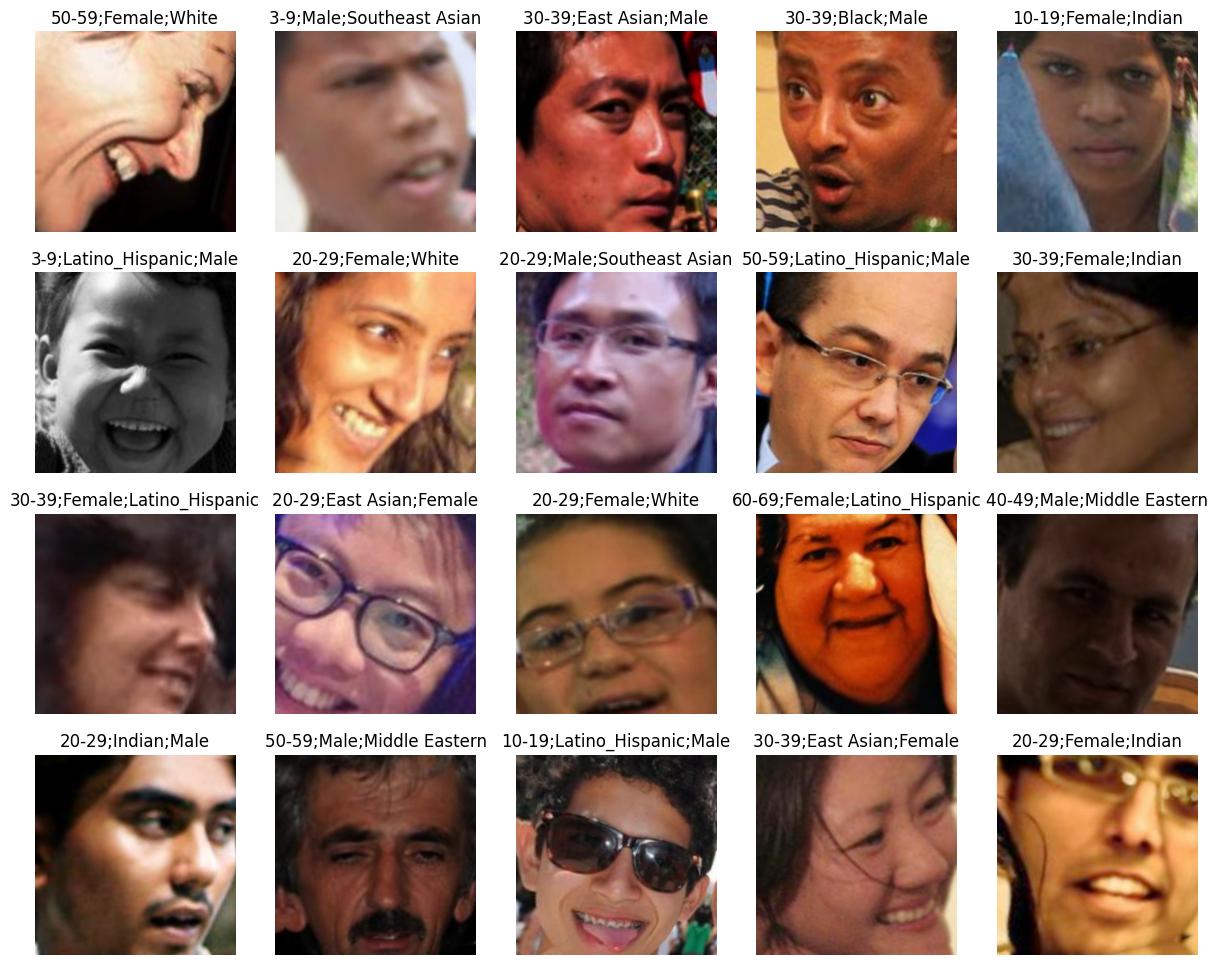

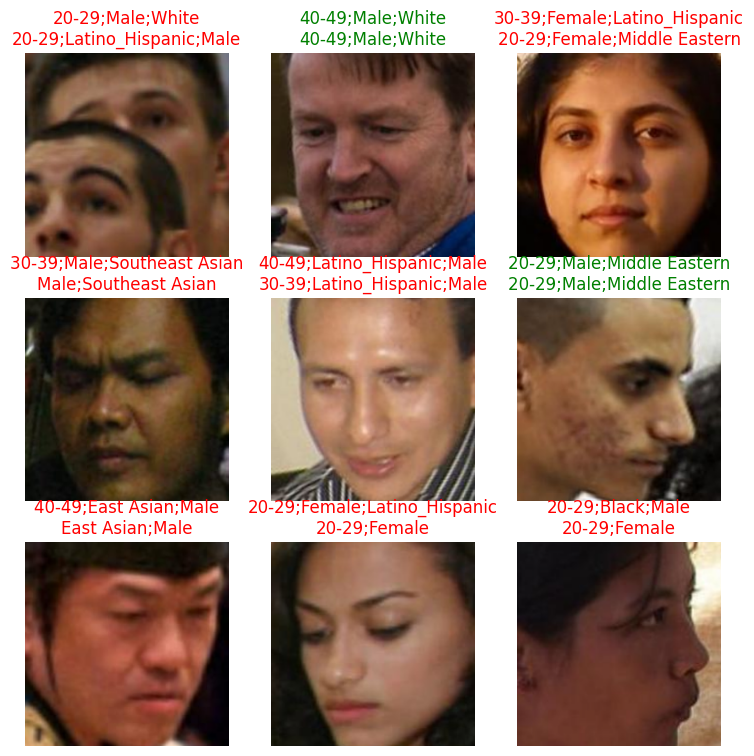

In [4]:
learn = train_fairface_model(train_df, resnet34, epochs=10, bs=64, lr=1e-3)
learn.show_results()

In [6]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN(
    image_size=224,
    margin=20,
    keep_all=True,
    post_process=True,
    select_largest=False,
    thresholds=[0.6, 0.7, 0.7]  
)

def detect_face_mtcnn(image_path):
    img = Image.open(image_path).convert('RGB')
    faces, _ = mtcnn.detect(img)
    
    if faces is None:
        return img 

    face_images = []
    for (x1, y1, x2, y2) in faces:
        face = img.crop((x1, y1, x2, y2))
        face_images.append(face)
    
    return face_images[0] if face_images else img

age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']

img_face = detect_face_mtcnn('./Dataset/val/121.jpg')
pred, pred_idx, probs = learn.predict(img_face)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

print("Age Category Probabilities:")
for label, prob in zip(age_labels, age_probs):
    print(f'{label}: {prob:.4f}')

print("\nGender Category Probabilities:")
for label, prob in zip(gender_labels, gender_probs):
    print(f'{label}: {prob:.4f}')

print("\nRace Category Probabilities:")
for label, prob in zip(race_labels, race_probs):
    print(f'{label}: {prob:.4f}')

Age Category Probabilities:
0-2: 0.0019
3-9: 0.0862
10-19: 0.4874
20-29: 0.0085
30-39: 0.3681
40-49: 0.0700
50-59: 0.0058
60-69: 0.0009
more than 70: 0.0067

Gender Category Probabilities:
Male: 0.1980
Female: 0.7976

Race Category Probabilities:
White: 0.0150
Black: 0.0808
East Asian: 0.2024
Southeast Asian: 0.0005
Indian: 0.6842
Middle Eastern: 0.0030
Latino_Hispanic: 0.0000
